In [145]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import corner

import retrieval_base.auxiliary_functions as af

In [5]:
def read_posterior(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud.npy')

    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud


posterior_1, bestfit_1, PT_1, Chem_1, int_contr_em_1, int_contr_em_per_order_1, int_opa_cloud_1 = \
    read_posterior(
    prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_186/test_', 
    n_params=30
    )

print(posterior_1.shape)

  analysing data from ./retrieval_outputs/DENIS_J0255_retrieval_outputs_186/test_.txt
(1888, 30)


In [323]:
#posterior_color = 'C0'
#posterior_color = plt.get_cmap('RdPu')(0.85)
posterior_color = plt.get_cmap('RdPu')(0.85)
bins = 25

envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=['w', posterior_color], 
    )
envelope_colors = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
envelope_colors[0,-1] = 0.0

indices = [9,14,15,16,17,18]
#indices = [8,10,19,20, 9,14,15,16,17,18]
indices = [8,9,14,15,16,17,18]
labels = [
    r'$R\ (R_\mathrm{Jup})$', #r'$R$', 
    #r'$\varepsilon_\mathrm{limb}$', 
    #r'$v\sin i$', 
    #r'$v_\mathrm{rad}$', 
    r'$\log\ g$', #r'$\log\ g\ (\mathrm{cm\ s^{-2}})$',
    r'$\log\ \mathrm{^{12}CO}$', 
    r'$\log\ \mathrm{H_2O}$', 
    r'$\log\ \mathrm{CH_4}$', 
    r'$\log\ \mathrm{NH_3}$', 
    r'$\log\ ^{13}\mathrm{CO}$', 
    ]

# Compute the 0.16, 0.5, and 0.84 quantiles
param_quantiles = np.array(
    [af.quantiles(posterior_1[:,i], q=[0.16,0.5,0.84]) for i in range(posterior_1.shape[1])]
    )
# Base the axes-limits off of the quantiles
param_range = np.array(
    #[(4*(q_i[0]-q_i[1])+q_i[1], 4*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    [(5*(q_i[0]-q_i[1])+q_i[1], 5*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    )
    
median_params = np.array(list(param_quantiles[:,1]))

fig = plt.figure(figsize=(10,10))

fig = corner.corner(
    posterior_1[:,indices], 
    fig=fig, 
    
    labels=labels, 
    show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    labelpad=0.08, 
    range=param_range[indices], 
    bins=bins, 
    max_n_ticks=3, 

    quantiles=[0.16,0.84,0.50], 
    color=posterior_color, 
    linewidths=0.5, 
    hist_kwargs={
        'edgecolor':posterior_color, 
        'facecolor':envelope_colors[1], 
        'fill':True
        }, 

    #levels=(1-np.exp(-0.5),),
    fill_contours=True, 
    plot_datapoints=True, 

    contourf_kwargs={'colors':envelope_colors}, 
    smooth=False, 

    contour_kwargs={'linewidths':0.5}, 
    )

# Add the best-fit and median values as lines
#corner.overplot_lines(fig, self.bestfit_params[mask_params], c=self.bestfit_color, lw=0.5)
#corner.overplot_lines(fig, median_params[indices], c=posterior_color, lw=1)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].tick_params(top=(i!=j), right=(i!=j), direction='inout')

for i in range(ax.shape[0]):
    # Change linestyle of 16/84th percentile in histograms
    ax[i,i].get_lines()[0].set(linewidth=1, linestyle=(5,(5,5)))
    ax[i,i].get_lines()[1].set(linewidth=1, linestyle=(5,(5,5)))

    ax[i,i].get_lines()[2].set(linewidth=1, linestyle='-')

    # Adjust the axis-limits
    for j in range(i):
        ax[i,j].set(ylim=param_range[indices][i])
    for h in range(ax.shape[0]):
        ax[h,i].set(xlim=param_range[indices][i])

ax[0,0].get_xlabel()

l, r = 0.07, 0.95
b, t = 0.07, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

#x0, y0 = 0.59, 0.59
x0, y0 = 0.62, 0.62; r, t = 0.97, 0.97
ax_PT = fig.add_axes([x0,y0,r-x0,t-y0])#, autoscale_on=False)
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(0,3200), xlabel=r'$T\ (\mathrm{K})$', 
    )
ax_PT.invert_yaxis()

for i in range(3):
    ax_PT.fill_betweenx(
        y=PT.pressure, x1=PT.temperature_envelopes[i], 
        x2=PT.temperature_envelopes[-i-1], 
        color=envelope_colors[i+1], ec='none', 
        )

# Plot the median PT
ax_PT.plot(
    PT.temperature_envelopes[3], PT.pressure, c=posterior_color, lw=1
    )

SONORA_temperature = np.loadtxt('./retrieval_outputs/DENIS_J0255_retrieval_outputs_synthetic_18/test_data/SONORA_temperature.dat')
SONORA_RCB = np.loadtxt('./retrieval_outputs/DENIS_J0255_retrieval_outputs_synthetic_18/test_data/SONORA_RCB.dat').flatten()[0]
ax_PT.plot(SONORA_temperature, PT.pressure, c='k', lw=1, )#ls=(5,(5,5)))
ax_PT.plot(
    np.interp(SONORA_RCB, xp=PT.pressure, fp=SONORA_temperature), SONORA_RCB, 'ko'
    )

ax_contr = ax_PT.twiny()
#ax_contr.plot(integrated_contr_em, PT.pressure, c=bestfit_color, ls='--', alpha=0.7)

#ax_contr.set(xlim=(0, 1.1*np.nanmax(int_contr_em)))
#ax_contr.tick_params(
#    axis='x', which='both', top=False, labeltop=False
#    )

fig.savefig('./plots/nominal_corner.pdf')
plt.close(fig)

In [264]:
'''
posterior_color = plt.get_cmap('RdPu')(0.85)
bins = 20

envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=['w', posterior_color], 
    )
envelope_colors = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
envelope_colors[0,-1] = 0.0

indices = [9,14,15,16,17,18]
labels = [
    r'$\log\ g$', 
    r'$\log\ \mathrm{^{12}CO}$', 
    r'$\log\ \mathrm{H_2O}$', 
    r'$\log\ \mathrm{CH_4}$', 
    r'$\log\ \mathrm{NH_3}$', 
    r'$\log\ ^{13}\mathrm{CO}$', 
    ]

# Compute the 0.16, 0.5, and 0.84 quantiles
param_quantiles = np.array(
    [af.quantiles(posterior_1[:,i], q=[0.16,0.5,0.84]) for i in range(posterior_1.shape[1])]
    )
# Base the axes-limits off of the quantiles
param_range = np.array(
    [(4*(q_i[0]-q_i[1])+q_i[1], 4*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    )
    
median_params = np.array(list(param_quantiles[:,1]))

fig = plt.figure(figsize=(10,10))

fig = corner.corner(
    posterior_1[:,indices], 
    fig=fig, 
    
    labels=labels, 
    show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10}, 
    #labelpad=0.25*n_params/17, 
    range=param_range[indices], 
    bins=bins, 
    max_n_ticks=3, 

    quantiles=[0.16,0.84], 
    color=posterior_color, 
    linewidths=0.5, 
    hist_kwargs={
        'edgecolor':posterior_color, 
        'facecolor':envelope_colors[1], 
        'fill':True
        }, 

    #levels=(1-np.exp(-0.5),),
    fill_contours=True, 
    plot_datapoints=True, 

    contourf_kwargs={'colors':envelope_colors}, 
    smooth=False, 

    contour_kwargs={'linewidths':0.5}, 
    )

# Add the best-fit and median values as lines
#corner.overplot_lines(fig, self.bestfit_params[mask_params], c=self.bestfit_color, lw=0.5)
corner.overplot_lines(fig, median_params[indices], c=posterior_color, lw=1)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
for ax_i in ax:
    ax_i.tick_params(axis='both', direction='inout')

ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

for i in range(ax.shape[0]):
    # Change linestyle of 16/84th percentile in histograms
    ax[i,i].get_lines()[0].set(linewidth=1, linestyle=(5,(5,5)))
    ax[i,i].get_lines()[1].set(linewidth=1, linestyle=(5,(5,5)))

    # Adjust the axis-limits
    for j in range(i):
        ax[i,j].set(ylim=param_range[indices][i])
    for h in range(ax.shape[0]):
        ax[h,i].set(xlim=param_range[indices][i])


l, r = 0.08, 0.92
b, t = 0.08, 0.92
fig.subplots_adjust(left=l, right=r, top=t, bottom=b)
fig.subplots_adjust(wspace=0, hspace=0)

#x0, y0 = 0.58, 0.58
#ax_PT = fig.add_axes([x0,y0,r-x0,t-y0])

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):

        if i < j-1:
            ax[i,j].set_frame_on(True)
            ax[i,j].set_facecolor('0.9')

            l, b, w, h = ax[i,j].get_position().bounds
            #ax[i,j].set_position([l+0.02, b+0.02, w, h])
            #ax[i,j].set_position([l, b+0.04, w, h])
            ax[i,j].set_position([l+w/4, b+h/4, w, h])

#fig.tight_layout(rect=[0.08,0.08,1.0,1.0], h_pad=0, w_pad=0)
#fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig('./plots/nominal_corner.pdf')
plt.close(fig)
'''

In [457]:
q = [0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2] 
param_quantiles = np.array(
    [af.quantiles(posterior_1[:,i], q=q) for i in range(posterior_1.shape[1])]
    )

fig = plt.figure(figsize=(10,4))

gs = mpl.gridspec.GridSpec(ncols=3, nrows=2, figure=fig, width_ratios=[1,0.6,0.6], wspace=0.1, hspace=0.4)

ax_VMR = fig.add_subplot(gs[:,0])

colors = ['C2', 'C3', 'C4', 'C8', 'C5']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$', r'$^{13}$CO']
for i, idx in enumerate([14,15,16,17,18]):
    if idx == 18:
        continue

    ax_VMR.errorbar(
        10**param_quantiles[idx,3], 10**(1.5), 
        #xerr=np.abs(10**param_quantiles[idx,[0,-1]]-10**param_quantiles[idx,3])[:,None], 
        xerr=np.abs(10**param_quantiles[idx,[1,-2]]-10**param_quantiles[idx,3])[:,None], 
        fmt='o', #capsize=2, 
        c=colors[i], capthick=2, elinewidth=2, label=labels[i], 
        markersize=4, 
        #fmt='s', markersize=5, elinewidth=2
    )

ax_VMR.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-6.5),10**(-3)), xlabel=r'$\mathrm{VMR}$', 
    )
ax_VMR.invert_yaxis()

ax_VMR.legend(loc='upper left')

ax_hist1d = np.array([
    fig.add_subplot(gs[0,1]), 
    fig.add_subplot(gs[1,1]), 
    fig.add_subplot(gs[0,2]), 
    fig.add_subplot(gs[1,2]), 
])

labels = ['C/O', '[Fe/H] or [C/H]', r'$^{12}$C/$^{13}$C', 'none']

for i, ax_i in enumerate(ax_hist1d):
    ax_i.set_yticks([])
    ax_i.set(xlabel=labels[i])

ax_hist1d[0].set(xlim=(0.5,0.75))
ax_hist1d[1].set(xlim=(-0.4,0.4))
ax_hist1d[2].set(xlim=(90,160))

ax_hist1d[3].legend(loc='upper left')
ax_hist1d[3].set_axis_off()
#ax_hist1d[3].set(xlim=())

#ax.spines[['right', 'top']].set_visible(False)


l, r = 0.08, 0.97
b, t = 0.13, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

fig.savefig('./plots/chemistry.pdf')
plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


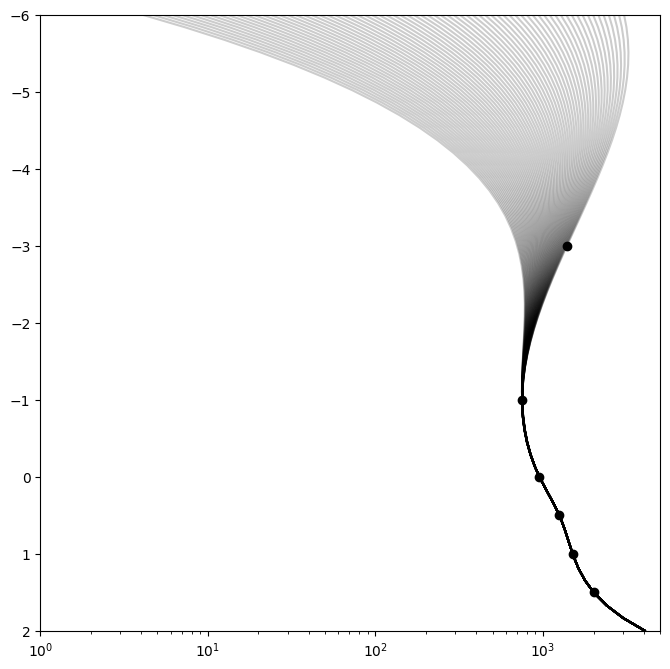

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev

#T_knots = np.array([2000,1500,1250,950,750,750])
#T_knots = np.array([2000,1500,1250,950,750,1450])
#log_P_knots = np.array([1.5,1,0.5,0,-1,-3])

plt.figure(figsize=(8,8))

for T_i in 750+np.arange(-50,650,10):

    T_knots = np.array([2000,1500,1250,950,750,T_i])
    log_P_knots = np.array([1.5,1,0.5,0,-1,-3])

    knots, coeffs, deg = splrep(log_P_knots[::-1], np.log10(T_knots[::-1]))

    temperature = 10**splev(np.linspace(-6,2,50), (knots, coeffs, deg), der=0)

    plt.plot(temperature, np.linspace(-6,2,50), c='k', alpha=0.2)
    
plt.plot(T_knots, log_P_knots, 'ko')
plt.xlim(1,5000)
plt.ylim(2,-6)
plt.xscale('log')
plt.show()
